# Neural Network Learning

Recreation of Andrew Ng Octave course 
using Python Jupyter Notebook by Alek Zdziarski

In [1]:
# import key libraries (remember to pip install numpy etc. first)
import numpy as np
import sys
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25 # 25 hidden units
num_labels = 10 # 10 labels, from 1 to 10
                          # (note that we have mapped "0" to label 10)

## Part 1: Loading and Visualizing Data

In [3]:
def display_data(s):
    fig, axarr = plt.subplots(nrows=10, ncols=10,figsize=(10,10))    
    for i in range(10):
        for j in range(10):
            ind = np.random.randint(s.shape[0])
            tmp = s[ind,:].reshape(20,20, order='F')
            axarr[i,j].imshow(tmp, cmap='gray_r')
            plt.setp(axarr[i,j].get_xticklabels(), visible=False)
            plt.setp(axarr[i,j].get_yticklabels(), visible=False)
    fig.subplots_adjust(hspace=0, wspace=0) 

Loading and Visualizing Data ...


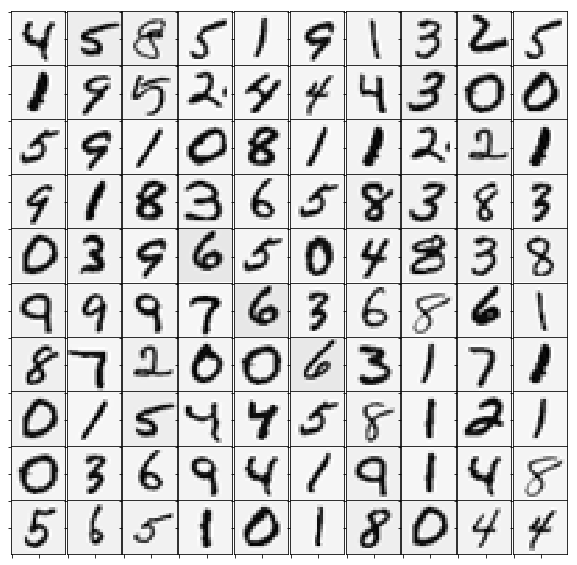

In [4]:
# Load Training Data
print('Loading and Visualizing Data ...')

# import csv data
#PATH="/Users/alek/OneDrive/Projects/Courses/Machine Learning Andrew Ng, Stanford, Coursera/ex4 Neural Net Learning/ex4/"
PATH="./data/"
DATA="ex4data1.mat"

import scipy.io
mat = scipy.io.loadmat(f'{PATH}{DATA}') # training data stored in arrays X, y
X = mat['X']
y = mat['y']

#convert 10s to 0s as python is 0 indexed so this will be preferred when building ys array
tenrows = np.where(y==10)
y[tenrows]=0

m = X.shape[0]

# Randomly select 100 data points to display
sel = np.random.choice(m,100,replace=False)

display_data(X[sel, :])

## Part 2: Loading Parameters

In [5]:
print('\nLoading Saved Neural Network Parameters ...\n')

# Load the weights into variables Theta1 and Theta2
DATA="ex4weights.mat"

import scipy.io
mat = scipy.io.loadmat(f'{PATH}{DATA}') # training data stored in arrays X, y

Theta1 = mat['Theta1']
Theta2 = mat['Theta2']

nn_params = np.r_[Theta1.ravel(), Theta2.ravel()]



Loading Saved Neural Network Parameters ...



## Part 3: Compute Cost (Feedforward)

In [6]:
def sigmoid(z):
    return 1/(1+ np.exp(-z))

def sigmoid_gradient(z):
#SIGMOIDGRADIENT returns the gradient of the sigmoid function
#evaluated at z
#   g = SIGMOIDGRADIENT(z) computes the gradient of the sigmoid function
#   evaluated at z. This should work regardless if z is a matrix or a
#   vector. In particular, if z is a vector or matrix, you should return
#   the gradient for each element.
    return sigmoid(z)*(1 - sigmoid(z))

def nn_cost_function(nn_params, input_layer_size, hidden_layer_size,num_labels, X, y, Lambda):
    # NNCOSTFUNCTION Implements the neural network cost function for a two layer
    # neural network which performs classification
    #   [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
    #   X, y, lambda) computes the cost and gradient of the neural network. The
    #   parameters for the neural network are "unrolled" into the vector
    #   nn_params and need to be converted back into the weight matrices.
    #
    #   The returned parameter grad should be a "unrolled" vector of the
    #   partial derivatives of the neural network.
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    
    Theta1 = nn_params[0:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, (input_layer_size + 1))
    
    Theta2 = nn_params[(hidden_layer_size * (input_layer_size + 1)):].reshape(num_labels, (hidden_layer_size + 1))
    
    # Setup some useful variables
    m = X.shape[0]
    n = X.shape[1]
    
    # calculate hypothesis h_theta
    
    bias = np.ones((m, 1))#ones(size(X,1))(:,1); %need ones all the way down to implement weights for bias
    
    a1 = np.c_[bias, X] # 5000 x 401 matrix
    
    z2 = (Theta1 @ a1.T).T # 5000 x 25 matrix
    a2_nobias = sigmoid(z2) # 5000 x 25 matrix
    a2 = np.c_[bias, a2_nobias] # 5000 x 26 matrix

    z3 = (Theta2 @ a2.T).T # 5000 x 10 matrix
    a3_nobias = sigmoid(z3) # 5000 x 10 matrix
    a3 = np.c_[bias, a3_nobias] # 5000 x 11 matrix
    
    h_theta = a3_nobias # 5000 x 10 matrix - for completeness we identify h_theta
    
    k = num_labels # number of output classes k
          
    # generate y vectors

    ys = (y*np.ones((m, k)) == np.arange(0,k)) # make 0/1 vectors for all 5000 mesaurements. 5000 x 10 matrix

    # let's put it in the shape this algorithm expects with the tenth column representing zero
    ys = np.c_[ys[:,1:], ys[:,0]]
    
    # calculate cost per y and h_theta

    cost = -1.*ys*np.log(h_theta) - (1-ys)*np.log(1-h_theta) # 5000 x 10 matrix
    sum_ks = np.sum(cost,1)
    sum_ms = np.sum(sum_ks)
    
    # compute regularization against all non-zero indexed theta. Remembering Octave puts that at position 1
    # note this code only works for two layers but their Theta1 and 2 concepts only works for it, so its not a prob
    
    Theta1_squ_sum = np.sum(np.sum(Theta1[:,1:]**2)) # remember excluding first element
    Theta2_squ_sum = np.sum(np.sum(Theta2[:,1:]**2))
    regularization = Lambda / (2*m) * (Theta1_squ_sum + Theta2_squ_sum)

    # calculate cost function output J
    
    J = sum_ms / m + regularization

    # calculate back propogation gradients
          
    delta_3s = h_theta - ys # 5000 x 10 matrix

    delta_2s = delta_3s @ Theta2[:,1:]*sigmoid_gradient(z2) # 5000 x 25 matrix

    DELTA2 = delta_3s.T @ a2 # 10 x 26 matrix

    DELTA1 = delta_2s.T @ a1 # 25 x 401 matrix

    lambda_m_Theta2 = Lambda / m * Theta2
    gradreg_layer_2 = np.c_[np.zeros((Theta2.shape[0],1)), lambda_m_Theta2[:,1:]] # 10 26

    lambda_m_Theta1 = Lambda / m * Theta1
    gradreg_layer_1 = np.c_[np.zeros((Theta1.shape[0],1)), lambda_m_Theta1[:,1:]] # 25 x 401

    Theta2_grad = DELTA2/m + gradreg_layer_2
    Theta1_grad = DELTA1/m + gradreg_layer_1
    
    # Unroll gradients and return
    grad = np.r_[Theta1_grad.ravel(), Theta2_grad.ravel()];
          
    return J, grad

In [7]:
print('\nFeedforward Using Neural Network ...\n')

# Weight regularization parameter (we set this to 0 here).
Lambda = 0

J, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)

print(f'Cost at parameters (loaded from ex4weights): {J:.6f} (this value should be about 0.287629)\n')


Feedforward Using Neural Network ...

Cost at parameters (loaded from ex4weights): 0.287629 (this value should be about 0.287629)



## Part 4: Implement Regularization

In [8]:
print('\nChecking Cost Function (w/ Regularization) ... \n')

# Weight regularization parameter (we set this to 1 here).
Lambda = 1

J, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)

print(f'Cost at parameters (loaded from ex4weights): {J:.6f} \n(this value should be about 0.383770)\n')


Checking Cost Function (w/ Regularization) ... 

Cost at parameters (loaded from ex4weights): 0.383770 
(this value should be about 0.383770)



## Part 5: Sigmoid Gradient 

In [9]:
print('\nEvaluating sigmoid gradient...\n')

g = sigmoid_gradient(np.matrix('[-1, -0.5, 0, 0.5, 1]').A)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)



Evaluating sigmoid gradient...

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]]


## Part 6: Initializing Pameters

In [10]:
def rand_initialize_weights(L_in, L_out):
#RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
#incoming connections and L_out outgoing connections
#   W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights
#   of a layer with L_in incoming connections and L_out outgoing
#   connections.
    epsilon_init = 0.12
    return np.random.uniform(size=(L_out, 1+L_in)) *2 * epsilon_init - epsilon_init
    
#  In this part of the exercise, you will be starting to implment a two
#  layer neural network that classifies digits. You will start by
#  implementing a function to initialize the weights of the neural network
#  (randInitializeWeights.m)

print('\nInitializing Neural Network Parameters ...\n')

initial_Theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
initial_Theta2 = rand_initialize_weights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.r_[initial_Theta1.ravel(), initial_Theta2.ravel()]
initial_nn_params.shape


Initializing Neural Network Parameters ...



(10285,)

## Part 7: Implement Backpropagation

In [11]:
def debug_initialize_weights(fan_out, fan_in):
# DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
# incoming connections and fan_out outgoing connections using a fixed
# strategy, this will help you later in debugging
#   W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
#   of a layer with fan_in incoming connections and fan_out outgoing 
#   connections using a fix set of values
#
#   Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
#   the first row of W handles the "bias" terms

    # Set W to zeros
    W = np.zeros((fan_out, 1 + fan_in))
    # Initialize W using "sin", this ensures that W is always of the same
    # values and will be useful for debugging
    W = np.sin(np.arange(W.size)+1).reshape(W.shape)/10
    return W

In [12]:
def compute_numerical_gradient(J, theta):
# COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
# and gives us a numerical estimate of the gradient.
#   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
#   gradient of the function J around theta. Calling y = J(theta) should
#   return the function value at theta.

# Notes: The following code implements numerical gradient checking, and 
#        returns the numerical gradient.It sets numgrad(i) to (a numerical 
#        approximation of) the partial derivative of J with respect to the 
#        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
#        be the (approximately) the partial derivative of J with respect 
#        to theta(i).)                

    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4
    for p in np.arange(theta.size):
        # Set perturbation vector
        perturb.ravel()[p] = e
        loss1, g1 = J(theta - perturb)
        loss2, g2 = J(theta + perturb)
        # Compute Numerical Gradient
        numgrad.ravel()[p] = (loss2 - loss1) / (2*e)
        perturb.ravel()[p] = 0
    return numgrad


In [13]:
def check_nn_gradients(Lambda=0):
#CHECKNNGRADIENTS Creates a small neural network to check the
#backpropagation gradients
#   CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
#   backpropagation gradients, it will output the analytical gradients
#   produced by your backprop code and the numerical gradients (computed
#   using computeNumericalGradient). These two gradient computations should
#   result in very similar values.
    
    def cost_func(p):
        return nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)
    
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    # We generate some 'random' test data
    Theta1 = debug_initialize_weights(hidden_layer_size, input_layer_size)
    #print(Theta1)
    Theta2 = debug_initialize_weights(num_labels, hidden_layer_size)
    # Reusing debugInitializeWeights to generate X
    X  = debug_initialize_weights(m, input_layer_size - 1)
    y  = np.mod(np.arange(m)+1, num_labels).reshape(m,1) + 1
    
    #print(Theta1.shape, Theta2.shape)
    # Unroll parameters
    nn_params = np.r_[Theta1.ravel(), Theta2.ravel()]

    # Short hand for cost function
    cost, grad = cost_func(nn_params)
    numgrad = compute_numerical_gradient(cost_func, nn_params);
    
    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar. 
    #print(numgrad, grad)
    print(['The above two columns you get should be very similar.\n(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n']);

    # Evaluate the norm of the difference between two solutions.  
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    # in computeNumericalGradient.m, then diff below should be less than 1e-9
    diff = np.linalg.norm(numgrad-grad, ord=2)/np.linalg.norm(numgrad+grad, ord=2)

    print(f'If your backpropagation implementation is correct, then \nthe relative difference will be small (less than 1e-9).\nRelative Difference: {diff}\n')



In [14]:
#  Once your cost matches up with ours, you should proceed to implement the
#  backpropagation algorithm for the neural network. You should add to the
#  code you've written in nnCostFunction.m to return the partial
#  derivatives of the parameters.

print('\nChecking Backpropagation... \n')

#  Check gradients by running checkNNGradients
check_nn_gradients()





Checking Backpropagation... 

['The above two columns you get should be very similar.\n(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n']
If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9).
Relative Difference: 1.8939790743992444e-11



## Part 8: Implement Regularization

In [15]:
#  Once your backpropagation implementation is correct, you should now
#  continue to implement the regularization with the cost and gradient.

print('\nChecking Backpropagation (w/ Regularization) ... \n')

#  Check gradients by running checkNNGradients
Lambda = 3
check_nn_gradients(Lambda)

# Also output the costFunction debugging values
debug_J, grad  = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)

print(f'\nCost at (fixed) debugging parameters (w/ lambda = {Lambda}): {debug_J:.6f} \n(for lambda = 3, this value should be about 0.576051)')





Checking Backpropagation (w/ Regularization) ... 

['The above two columns you get should be very similar.\n(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n']
If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9).
Relative Difference: 1.882738002100198e-11


Cost at (fixed) debugging parameters (w/ lambda = 3): 0.576051 
(for lambda = 3, this value should be about 0.576051)


## Part 8: Training NN 

<li>  You have now implemented all the code necessary to train a neural
<li>  network. To train your neural network, we will now use "fmincg", which
<li>  is a function which works similarly to "fminunc". Recall that these
<li>  advanced optimizers are able to train our cost functions efficiently as
<li>  long as we provide them with the gradient computations.


In [16]:
import scipy.optimize as opt  

In [18]:
import sys

count = 0

def callb(x):
    global count
    count += 1
    sys.stdout.write(f'{count}, ')

def costf(nnp, X, y, Lambda):
    nnp = nnp.reshape((nnp.size,1))
    return nn_cost_function(nnp, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)[0]
def gradf(nnp, X, y, Lambda):
    nnp = nnp.reshape((nnp.size,1))
    ret = nn_cost_function(nnp, input_layer_size, hidden_layer_size,num_labels, X, y, Lambda)[1]
    return ret

print('\nTraining Neural Network over about 150 iterations... This can take a minute\n')

#  After you have completed the assignment, change the MaxIter to a larger
#  value to see how more training helps.
#options = optimset('MaxIter', 200);

#  You should also try different values of lambda
Lambda = 1.5

# Create "short hand" for the cost function to be minimized
#costFunction = @(p) nnCostFunction(p, ...
#                                   input_layer_size, ...
#                                   hidden_layer_size, ...
#                                   num_labels, X, y, lambda);

# Now, costFunction is a function that takes in only one argument (the
# neural network parameters)
#[nn_params, cost] = fmincg(costFunction, initial_nn_params, options);

result = opt.fmin_tnc(func=costf, x0=initial_nn_params, fprime=gradf, args=(X, y, Lambda), disp=5, callback=callb)

nn_params = result[0]
print (nn_params.shape)
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = nn_params[0:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, (input_layer_size + 1))
    
Theta2 = nn_params[(hidden_layer_size * (input_layer_size + 1)):].reshape(num_labels, (hidden_layer_size + 1))

print(f'\nTraining complete: {Theta1.shape} {Theta2.shape}')



Training Neural Network over about 150 iterations... This can take a minutes

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, (10285,)

Training complete: (25, 401) (10, 26)


In [19]:
result

(array([  2.91611393e+00,   3.48631714e-14,  -4.58046517e-11, ...,
          1.92182661e+00,   4.11367363e-01,   5.52153536e-02]), 3453, 1)

## Part 9: Visualize Weights

In [20]:
def display_data_predictions(s, sh=20):
    count = s.shape[0]
    maxcols = 5
    if count > maxcols:
        cols = maxcols
        import math
        rows = math.ceil(count/maxcols)
    else:
        cols = count
        rows = 1

    fig, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

    cnt = 0
    for r in range(rows):
        for c in range (cols):
            #print (f'r {r}, c {c}, cnt {cnt}')
            ind = np.random.randint(s.shape[0])
            tmp = s[cnt,:].reshape(sh,sh, order='F')
            axarr[r,c].imshow(tmp, cmap='gray_r')
            plt.setp(axarr[r,c].get_xticklabels(), visible=False)
            plt.setp(axarr[r,c].get_yticklabels(), visible=False)
            axarr[r,c].set_title(f'{r} {c}')
            cnt += 1
            if cnt >= count:
                break
    fig.subplots_adjust(hspace=1, wspace=1) 


Visualizing Neural Network Theta 1... (25, 401)
Visualizing Neural Network Theta 2... (10, 26)


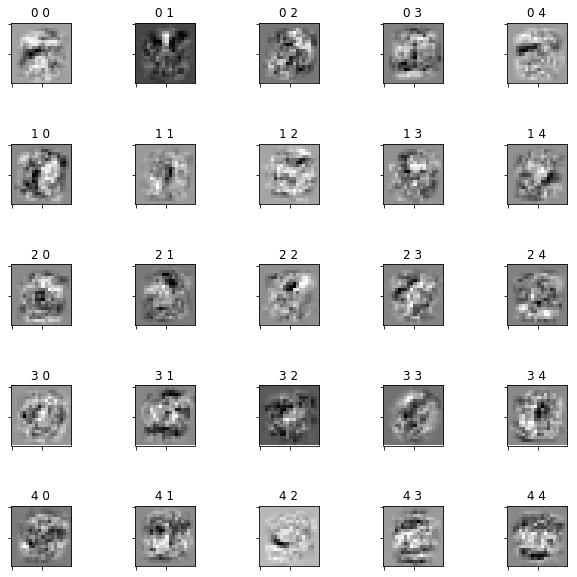

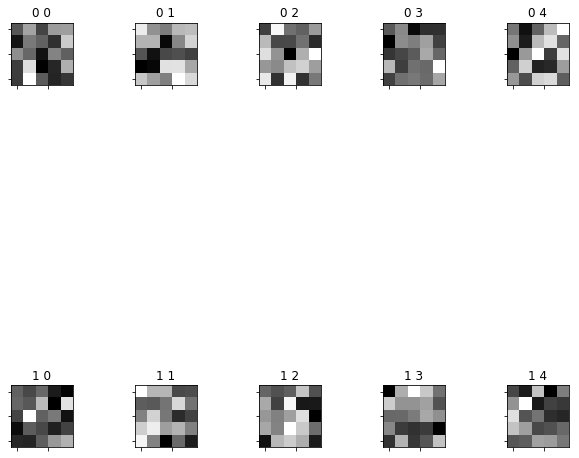

In [21]:
#  You can now "visualize" what the neural network is learning by
#  displaying the hidden units to see what features they are capturing in
#  the data.

f1 = plt.figure()

print(f'\nVisualizing Neural Network Theta 1... {Theta1.shape}')

display_data_predictions(Theta1[:, 1:])

f2 = plt.figure()

print(f'Visualizing Neural Network Theta 2... {Theta2.shape}')

display_data_predictions(Theta2[:, 1:],5)



## Part 10: Implement Predict

In [22]:
def predict(Theta1, Theta2, X):
#PREDICT Predict the label of an input given a trained neural network
#   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
#   trained weights of a neural network (Theta1, Theta2)

    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly 
    #p = np.zeros((m, 1))

    h1 = sigmoid(np.c_[np.ones((m, 1)), X] @ Theta1.T)
    h2 = sigmoid(np.c_[np.ones((m, 1)), h1] @ Theta2.T)

    p=np.argmax(h2, axis=1)

    return p
#[dummy, p] = max(h2, [], 2);


In [26]:
#  After training the neural network, we would like to use it to predict
#  the labels. You will now implement the "predict" function to use the
#  neural network to predict the labels of the training set. This lets
#  you compute the training set accuracy.

pred = predict(Theta1, Theta2, X)+1 #predictions are 0-9 but actually represent digits 1 through 10
pred = pred.reshape(m,1)
#convert 0s to 10s as python to make both data sets comparable
yfix=y
tenrows = np.where(yfix==0)
yfix[tenrows]=10

print(f'Training Set Accuracy: {np.mean(np.double(pred == yfix)) * 100}')

Training Set Accuracy: 99.1


In [34]:
# show 50 random predictions vs. y
rd = np.random.choice(m, 50, replace=False)
pred[rd].T, yfix[rd].T, f'{np.sum((pred[rd]==y[rd])*1.):.0f} out of 50'

(array([[ 4,  8,  9, 10,  8,  6,  2,  8,  8,  1,  1,  9,  9,  4,  5,  2,  8,
          1,  2,  4,  2,  6,  4,  9,  3,  6,  1,  2,  2,  5,  9,  4,  7,  7,
          8,  9,  5,  5,  3,  1,  7,  1,  2,  9,  3,  1, 10,  5,  8,  6]]),
 array([[ 4,  8,  9, 10,  8,  6,  2,  8,  8,  1,  1,  9,  9,  4,  5,  2,  8,
          5,  2,  4,  2,  6,  4,  9,  3,  6,  1,  2,  2,  5,  9,  4,  7,  7,
          8,  9,  5,  5,  3,  1,  7,  1,  2,  9,  3,  1, 10,  5,  8,  6]], dtype=uint8),
 '49 out of 50')